In [68]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net
from ImageLoader import ImageLoader2D

In [69]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [70]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "DuckNet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.9

In [71]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 40


40it [00:05,  7.00it/s]


In [72]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [73]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [74]:
# Creating the model

model = DUCK_Net.create_model(img_height=img_size, img_width=img_size, input_chanels=3, out_classes=1, starting_filters=filters)

Starting DUCK-Net


In [75]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [76]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
8/8 [==============================] - 49s 1s/step - loss: 0.7937 - val_loss: 1.0000
Loss Validation: 1.0
Loss Test: 1.0
Training, epoch 1
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.7317 - val_loss: 1.0000
Loss Validation: 1.0
Loss Test: 1.0
Training, epoch 2
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.7248 - val_loss: 1.0000
Loss Validation: 1.0
Loss Test: 1.0
Training, epoch 3
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.7038 - val_loss: 1.0000
Loss Validation: 1.0
Loss Test: 1.0
Training, epoch 4
Learning Rate: 0.0001
8/8 [==============================] - 6s 713ms/step - loss: 0.7141 - val_loss: 1.0000
Loss Validation: 1.0
Loss Test: 1.0
Training, epoch 5
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.6741 - val_loss: 0.8224
Loss Validation: 0.8224009
Loss Test: 0.9701411
Saved model 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 6
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.6620 - val_loss: 0.7975
Loss Validation: 0.7975126
Loss Test: 0.7881576
Saved model with val_loss:  0.7975126


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 7
Learning Rate: 0.0001
8/8 [==============================] - 6s 712ms/step - loss: 0.6408 - val_loss: 0.8424
Loss Validation: 0.8424399
Loss Test: 0.80738074
Training, epoch 8
Learning Rate: 0.0001
8/8 [==============================] - 6s 714ms/step - loss: 0.6627 - val_loss: 0.8225
Loss Validation: 0.8224511
Loss Test: 0.7931932
Training, epoch 9
Learning Rate: 0.0001
8/8 [==============================] - 6s 716ms/step - loss: 0.6289 - val_loss: 0.8133
Loss Validation: 0.81334066
Loss Test: 0.7766446
Training, epoch 10
Learning Rate: 0.0001
8/8 [==============================] - 6s 717ms/step - loss: 0.6094 - val_loss: 0.8235
Loss Validation: 0.82348895
Loss Test: 0.8001192
Training, epoch 11
Learning Rate: 0.0001
8/8 [==============================] - 6s 719ms/step - loss: 0.6497 - val_loss: 0.8030
Loss Validation: 0.8030182
Loss Test: 0.776442
Training, epoch 12
Learning Rate: 0.0001
8/8 [==============================] - 6s 717ms/step - loss: 0.6378 - val_loss: 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 14
Learning Rate: 0.0001
8/8 [==============================] - 6s 705ms/step - loss: 0.6439 - val_loss: 0.8120
Loss Validation: 0.81199133
Loss Test: 0.77805406
Training, epoch 15
Learning Rate: 0.0001
8/8 [==============================] - 6s 705ms/step - loss: 0.5908 - val_loss: 0.8001
Loss Validation: 0.80006164
Loss Test: 0.7435583
Training, epoch 16
Learning Rate: 0.0001
8/8 [==============================] - 6s 715ms/step - loss: 0.6118 - val_loss: 0.8613
Loss Validation: 0.8613383
Loss Test: 0.8346449
Training, epoch 17
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.5939 - val_loss: 0.8322
Loss Validation: 0.8322355
Loss Test: 0.8136379
Training, epoch 18
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.5714 - val_loss: 0.8605
Loss Validation: 0.860493
Loss Test: 0.86379755
Training, epoch 19
Learning Rate: 0.0001
8/8 [==============================] - 6s 710ms/step - loss: 0.6218 - val_lo

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 21
Learning Rate: 0.0001
8/8 [==============================] - 6s 707ms/step - loss: 0.5731 - val_loss: 0.8866
Loss Validation: 0.88662684
Loss Test: 0.8666273
Training, epoch 22
Learning Rate: 0.0001
8/8 [==============================] - 6s 707ms/step - loss: 0.5913 - val_loss: 0.8940
Loss Validation: 0.89403886
Loss Test: 0.88401794
Training, epoch 23
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.5961 - val_loss: 0.8690
Loss Validation: 0.8689598
Loss Test: 0.7995099
Training, epoch 24
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.6165 - val_loss: 0.8058
Loss Validation: 0.8057536
Loss Test: 0.85585415
Training, epoch 25
Learning Rate: 0.0001
8/8 [==============================] - 6s 717ms/step - loss: 0.5338 - val_loss: 0.8722
Loss Validation: 0.8722241
Loss Test: 0.9069204
Training, epoch 26
Learning Rate: 0.0001
8/8 [==============================] - 6s 712ms/step - loss: 0.5634 - val_l

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 29
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.5478 - val_loss: 0.7658
Loss Validation: 0.76579726
Loss Test: 0.71033514
Training, epoch 30
Learning Rate: 0.0001
8/8 [==============================] - 6s 707ms/step - loss: 0.5484 - val_loss: 0.8771
Loss Validation: 0.8771478
Loss Test: 0.91931283
Training, epoch 31
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.5287 - val_loss: 0.7776
Loss Validation: 0.77756256
Loss Test: 0.7503724
Training, epoch 32
Learning Rate: 0.0001
8/8 [==============================] - 6s 712ms/step - loss: 0.5148 - val_loss: 0.8382
Loss Validation: 0.838242
Loss Test: 0.9228424
Training, epoch 33
Learning Rate: 0.0001
8/8 [==============================] - 6s 710ms/step - loss: 0.5271 - val_loss: 0.9752
Loss Validation: 0.9751947
Loss Test: 0.97362393
Training, epoch 34
Learning Rate: 0.0001
8/8 [==============================] - 6s 711ms/step - loss: 0.5781 - val_l

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 41
Learning Rate: 0.0001
8/8 [==============================] - 6s 722ms/step - loss: 0.5142 - val_loss: 0.6803
Loss Validation: 0.6802803
Loss Test: 0.4205094
Training, epoch 42
Learning Rate: 0.0001
8/8 [==============================] - 6s 725ms/step - loss: 0.5167 - val_loss: 0.6901
Loss Validation: 0.69006276
Loss Test: 0.49684757
Training, epoch 43
Learning Rate: 0.0001
8/8 [==============================] - 6s 726ms/step - loss: 0.5456 - val_loss: 0.6253
Loss Validation: 0.6253234
Loss Test: 0.35192722
Saved model with val_loss:  0.6253234


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 44
Learning Rate: 0.0001
8/8 [==============================] - 6s 706ms/step - loss: 0.5056 - val_loss: 0.5529
Loss Validation: 0.552873
Loss Test: 0.34514338
Saved model with val_loss:  0.552873


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 45
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.4935 - val_loss: 0.6114
Loss Validation: 0.611372
Loss Test: 0.342005
Training, epoch 46
Learning Rate: 0.0001
8/8 [==============================] - 6s 706ms/step - loss: 0.5030 - val_loss: 0.5463
Loss Validation: 0.546281
Loss Test: 0.39186192
Saved model with val_loss:  0.546281


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 47
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.5189 - val_loss: 0.6071
Loss Validation: 0.60709536
Loss Test: 0.48496628
Training, epoch 48
Learning Rate: 0.0001
8/8 [==============================] - 6s 716ms/step - loss: 0.5029 - val_loss: 0.5710
Loss Validation: 0.571013
Loss Test: 0.46412337
Training, epoch 49
Learning Rate: 0.0001
8/8 [==============================] - 6s 724ms/step - loss: 0.5018 - val_loss: 0.6196
Loss Validation: 0.6196157
Loss Test: 0.52305055
Training, epoch 50
Learning Rate: 0.0001
8/8 [==============================] - 6s 725ms/step - loss: 0.4953 - val_loss: 0.6105
Loss Validation: 0.6105381
Loss Test: 0.44108647
Training, epoch 51
Learning Rate: 0.0001
8/8 [==============================] - 6s 725ms/step - loss: 0.4953 - val_loss: 0.6759
Loss Validation: 0.6759092
Loss Test: 0.30160344
Training, epoch 52
Learning Rate: 0.0001
8/8 [==============================] - 6s 727ms/step - loss: 0.4817 - val_

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 53
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.4914 - val_loss: 0.5401
Loss Validation: 0.54009354
Loss Test: 0.39362806
Training, epoch 54
Learning Rate: 0.0001
8/8 [==============================] - 6s 725ms/step - loss: 0.4961 - val_loss: 0.4884
Loss Validation: 0.48835033
Loss Test: 0.34714097
Training, epoch 55
Learning Rate: 0.0001
8/8 [==============================] - 6s 727ms/step - loss: 0.4379 - val_loss: 0.4875
Loss Validation: 0.4875179
Loss Test: 0.39816767
Training, epoch 56
Learning Rate: 0.0001
8/8 [==============================] - 6s 728ms/step - loss: 0.4541 - val_loss: 0.5379
Loss Validation: 0.5378955
Loss Test: 0.36294717
Training, epoch 57
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.4578 - val_loss: 0.4624
Loss Validation: 0.46240747
Loss Test: 0.34815258
Training, epoch 58
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.4390 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 63
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.5029 - val_loss: 0.3967
Loss Validation: 0.39671695
Loss Test: 0.34427124
Saved model with val_loss:  0.39671695


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 64
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.4600 - val_loss: 0.5408
Loss Validation: 0.54079795
Loss Test: 0.42731744
Training, epoch 65
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.4618 - val_loss: 0.6327
Loss Validation: 0.6327442
Loss Test: 0.47110862
Training, epoch 66
Learning Rate: 0.0001
8/8 [==============================] - 6s 728ms/step - loss: 0.4625 - val_loss: 0.5043
Loss Validation: 0.50430596
Loss Test: 0.38381666
Training, epoch 67
Learning Rate: 0.0001
8/8 [==============================] - 6s 734ms/step - loss: 0.4497 - val_loss: 0.4881
Loss Validation: 0.48809552
Loss Test: 0.39666897
Training, epoch 68
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.4504 - val_loss: 0.4059
Loss Validation: 0.40594423
Loss Test: 0.2900467
Training, epoch 69
Learning Rate: 0.0001
8/8 [==============================] - 6s 737ms/step - loss: 0.4750 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 87
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.3892 - val_loss: 0.4098
Loss Validation: 0.4097727
Loss Test: 0.31832778
Training, epoch 88
Learning Rate: 0.0001
8/8 [==============================] - 6s 727ms/step - loss: 0.4203 - val_loss: 0.4508
Loss Validation: 0.45080024
Loss Test: 0.28266096
Training, epoch 89
Learning Rate: 0.0001
8/8 [==============================] - 6s 728ms/step - loss: 0.4204 - val_loss: 0.4784
Loss Validation: 0.4783997
Loss Test: 0.32900065
Training, epoch 90
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.4154 - val_loss: 0.4724
Loss Validation: 0.47236687
Loss Test: 0.34073883
Training, epoch 91
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.4694 - val_loss: 0.4441
Loss Validation: 0.44412225
Loss Test: 0.29929364
Training, epoch 92
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3872 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 93
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.3975 - val_loss: 0.4468
Loss Validation: 0.44681054
Loss Test: 0.24541646
Training, epoch 94
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.4109 - val_loss: 0.4354
Loss Validation: 0.43537778
Loss Test: 0.23435885
Training, epoch 95
Learning Rate: 0.0001
8/8 [==============================] - 6s 729ms/step - loss: 0.4578 - val_loss: 0.3267
Loss Validation: 0.3267011
Loss Test: 0.19399697
Saved model with val_loss:  0.3267011


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 96
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3729 - val_loss: 0.3652
Loss Validation: 0.36524028
Loss Test: 0.19505858
Training, epoch 97
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.4690 - val_loss: 0.3470
Loss Validation: 0.3469931
Loss Test: 0.22589356
Training, epoch 98
Learning Rate: 0.0001
8/8 [==============================] - 6s 728ms/step - loss: 0.3841 - val_loss: 0.3385
Loss Validation: 0.3385498
Loss Test: 0.22937214
Training, epoch 99
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.3935 - val_loss: 0.3889
Loss Validation: 0.38886106
Loss Test: 0.1912297
Training, epoch 100
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3975 - val_loss: 0.3910
Loss Validation: 0.3909741
Loss Test: 0.25424802
Training, epoch 101
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.4560 - v

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 133
Learning Rate: 0.0001
8/8 [==============================] - 6s 729ms/step - loss: 0.3815 - val_loss: 0.4723
Loss Validation: 0.47225684
Loss Test: 0.24042284
Training, epoch 134
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.3108 - val_loss: 0.3412
Loss Validation: 0.3412308
Loss Test: 0.18353671
Training, epoch 135
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.3758 - val_loss: 0.6886
Loss Validation: 0.68859696
Loss Test: 0.5223356
Training, epoch 136
Learning Rate: 0.0001
8/8 [==============================] - 6s 736ms/step - loss: 0.3415 - val_loss: 0.4147
Loss Validation: 0.41470027
Loss Test: 0.18895453
Training, epoch 137
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3783 - val_loss: 0.4616
Loss Validation: 0.46161193
Loss Test: 0.180498
Training, epoch 138
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3317

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 139
Learning Rate: 0.0001
8/8 [==============================] - 6s 729ms/step - loss: 0.3560 - val_loss: 0.5738
Loss Validation: 0.5737789
Loss Test: 0.20242739
Training, epoch 140
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.3381 - val_loss: 0.4036
Loss Validation: 0.40357226
Loss Test: 0.20895064
Training, epoch 141
Learning Rate: 0.0001
8/8 [==============================] - 6s 728ms/step - loss: 0.3305 - val_loss: 0.4936
Loss Validation: 0.49360967
Loss Test: 0.18874717
Training, epoch 142
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3842 - val_loss: 0.5493
Loss Validation: 0.5493156
Loss Test: 0.24942559
Training, epoch 143
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3721 - val_loss: 0.4258
Loss Validation: 0.42578715
Loss Test: 0.1774733
Training, epoch 144
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.306

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 150
Learning Rate: 0.0001
8/8 [==============================] - 6s 734ms/step - loss: 0.3003 - val_loss: 0.4651
Loss Validation: 0.46509367
Loss Test: 0.17265081
Training, epoch 151
Learning Rate: 0.0001
8/8 [==============================] - 6s 729ms/step - loss: 0.3118 - val_loss: 0.2745
Loss Validation: 0.274544
Loss Test: 0.19593644
Saved model with val_loss:  0.274544


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 152
Learning Rate: 0.0001
8/8 [==============================] - 6s 735ms/step - loss: 0.3647 - val_loss: 0.2716
Loss Validation: 0.27164865
Loss Test: 0.15699339
Saved model with val_loss:  0.27164865


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 153
Learning Rate: 0.0001
8/8 [==============================] - 6s 729ms/step - loss: 0.3248 - val_loss: 0.3083
Loss Validation: 0.3082946
Loss Test: 0.12873304
Training, epoch 154
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.3014 - val_loss: 0.3433
Loss Validation: 0.34332114
Loss Test: 0.2394768
Training, epoch 155
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.3544 - val_loss: 0.2389
Loss Validation: 0.23888034
Loss Test: 0.19217926
Saved model with val_loss:  0.23888034


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 156
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.3151 - val_loss: 0.5744
Loss Validation: 0.5743921
Loss Test: 0.31985325
Training, epoch 157
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.3279 - val_loss: 0.2818
Loss Validation: 0.28183115
Loss Test: 0.17464292
Training, epoch 158
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3416 - val_loss: 0.4711
Loss Validation: 0.47105986
Loss Test: 0.15525144
Training, epoch 159
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.3444 - val_loss: 0.2931
Loss Validation: 0.29311258
Loss Test: 0.16815525
Training, epoch 160
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.3127 - val_loss: 0.3070
Loss Validation: 0.30702126
Loss Test: 0.18241054
Training, epoch 161
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.3

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 179
Learning Rate: 0.0001
8/8 [==============================] - 6s 727ms/step - loss: 0.2790 - val_loss: 0.2502
Loss Validation: 0.25023675
Loss Test: 0.15408903
Training, epoch 180
Learning Rate: 0.0001
8/8 [==============================] - 6s 728ms/step - loss: 0.2794 - val_loss: 0.2941
Loss Validation: 0.294129
Loss Test: 0.16403931
Training, epoch 181
Learning Rate: 0.0001
8/8 [==============================] - 6s 733ms/step - loss: 0.2889 - val_loss: 0.3281
Loss Validation: 0.32814097
Loss Test: 0.12861753
Training, epoch 182
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.2875 - val_loss: 0.2554
Loss Validation: 0.25540978
Loss Test: 0.14384896
Training, epoch 183
Learning Rate: 0.0001
8/8 [==============================] - 6s 737ms/step - loss: 0.2766 - val_loss: 0.2310
Loss Validation: 0.23098779
Loss Test: 0.16845417
Training, epoch 184
Learning Rate: 0.0001
8/8 [==============================] - 6s 736ms/step - loss: 0.28

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 209
Learning Rate: 0.0001
8/8 [==============================] - 6s 727ms/step - loss: 0.2995 - val_loss: 0.3587
Loss Validation: 0.3587476
Loss Test: 0.13257283
Training, epoch 210
Learning Rate: 0.0001
8/8 [==============================] - 6s 728ms/step - loss: 0.2556 - val_loss: 0.4104
Loss Validation: 0.41038162
Loss Test: 0.11506122
Training, epoch 211
Learning Rate: 0.0001
8/8 [==============================] - 6s 730ms/step - loss: 0.2384 - val_loss: 0.3008
Loss Validation: 0.30080897
Loss Test: 0.13763452
Training, epoch 212
Learning Rate: 0.0001
8/8 [==============================] - 6s 735ms/step - loss: 0.2588 - val_loss: 0.3817
Loss Validation: 0.38166136
Loss Test: 0.14006293
Training, epoch 213
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.2520 - val_loss: 0.2892
Loss Validation: 0.2892114
Loss Test: 0.12569475
Training, epoch 214
Learning Rate: 0.0001
8/8 [==============================] - 6s 737ms/step - loss: 0.27

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 257
Learning Rate: 0.0001
8/8 [==============================] - 6s 726ms/step - loss: 0.2305 - val_loss: 0.2537
Loss Validation: 0.25373262
Loss Test: 0.10943031
Training, epoch 258
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.2255 - val_loss: 0.2067
Loss Validation: 0.2067281
Loss Test: 0.11247957
Saved model with val_loss:  0.2067281


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 259
Learning Rate: 0.0001
8/8 [==============================] - 6s 729ms/step - loss: 0.2097 - val_loss: 0.1913
Loss Validation: 0.19132155
Loss Test: 0.14693028
Saved model with val_loss:  0.19132155


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 260
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.2310 - val_loss: 0.2513
Loss Validation: 0.25129092
Loss Test: 0.14591646
Training, epoch 261
Learning Rate: 0.0001
8/8 [==============================] - 6s 726ms/step - loss: 0.2277 - val_loss: 0.4753
Loss Validation: 0.47534603
Loss Test: 0.11458051
Training, epoch 262
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.2597 - val_loss: 0.3167
Loss Validation: 0.31671214
Loss Test: 0.114875495
Training, epoch 263
Learning Rate: 0.0001
8/8 [==============================] - 6s 732ms/step - loss: 0.2006 - val_loss: 0.1945
Loss Validation: 0.1945219
Loss Test: 0.10293418
Training, epoch 264
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.2295 - val_loss: 0.2336
Loss Validation: 0.23355395
Loss Test: 0.12537283
Training, epoch 265
Learning Rate: 0.0001
8/8 [==============================] - 6s 731ms/step - loss: 0.

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 285
Learning Rate: 0.0001
8/8 [==============================] - 6s 703ms/step - loss: 0.2157 - val_loss: 0.1855
Loss Validation: 0.1854657
Loss Test: 0.1148622
Training, epoch 286
Learning Rate: 0.0001
8/8 [==============================] - 6s 704ms/step - loss: 0.1995 - val_loss: 0.3314
Loss Validation: 0.3314311
Loss Test: 0.120501935
Training, epoch 287
Learning Rate: 0.0001
8/8 [==============================] - 6s 706ms/step - loss: 0.2364 - val_loss: 0.4372
Loss Validation: 0.43716282
Loss Test: 0.13118124
Training, epoch 288
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.2006 - val_loss: 0.4184
Loss Validation: 0.41835338
Loss Test: 0.11375356
Training, epoch 289
Learning Rate: 0.0001
8/8 [==============================] - 6s 707ms/step - loss: 0.2257 - val_loss: 0.4869
Loss Validation: 0.4868595
Loss Test: 0.10363966
Training, epoch 290
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.185

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 299
Learning Rate: 0.0001
8/8 [==============================] - 6s 701ms/step - loss: 0.2182 - val_loss: 0.1798
Loss Validation: 0.17976028
Loss Test: 0.12869924
Training, epoch 300
Learning Rate: 0.0001
8/8 [==============================] - 6s 704ms/step - loss: 0.1710 - val_loss: 0.3716
Loss Validation: 0.37159228
Loss Test: 0.09847379
Training, epoch 301
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.1815 - val_loss: 0.4650
Loss Validation: 0.46504515
Loss Test: 0.10194194
Training, epoch 302
Learning Rate: 0.0001
8/8 [==============================] - 6s 710ms/step - loss: 0.1925 - val_loss: 0.4334
Loss Validation: 0.4334067
Loss Test: 0.105136156
Training, epoch 303
Learning Rate: 0.0001
8/8 [==============================] - 6s 707ms/step - loss: 0.2202 - val_loss: 0.6285
Loss Validation: 0.6284785
Loss Test: 0.34604537
Training, epoch 304
Learning Rate: 0.0001
8/8 [==============================] - 6s 706ms/step - loss: 0.2

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 510
Learning Rate: 0.0001
8/8 [==============================] - 6s 704ms/step - loss: 0.1354 - val_loss: 0.2448
Loss Validation: 0.24478382
Loss Test: 0.08586103
Training, epoch 511
Learning Rate: 0.0001
8/8 [==============================] - 6s 704ms/step - loss: 0.1354 - val_loss: 0.4654
Loss Validation: 0.4654492
Loss Test: 0.20530003
Training, epoch 512
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.1190 - val_loss: 0.1714
Loss Validation: 0.17144215
Loss Test: 0.06936735
Training, epoch 513
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.1470 - val_loss: 0.2066
Loss Validation: 0.2065888
Loss Test: 0.08346385
Training, epoch 514
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.1394 - val_loss: 0.1878
Loss Validation: 0.187832
Loss Test: 0.074796975
Training, epoch 515
Learning Rate: 0.0001
8/8 [==============================] - 6s 710ms/step - loss: 0.129

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 540
Learning Rate: 0.0001
8/8 [==============================] - 6s 706ms/step - loss: 0.1328 - val_loss: 0.1791
Loss Validation: 0.17914647
Loss Test: 0.08463782
Training, epoch 541
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.1361 - val_loss: 0.1691
Loss Validation: 0.1690793
Loss Test: 0.090470195
Training, epoch 542
Learning Rate: 0.0001
8/8 [==============================] - 6s 707ms/step - loss: 0.1371 - val_loss: 0.1629
Loss Validation: 0.16293114
Loss Test: 0.089297295
Training, epoch 543
Learning Rate: 0.0001
8/8 [==============================] - 6s 711ms/step - loss: 0.1840 - val_loss: 0.1345
Loss Validation: 0.13452142
Loss Test: 0.08985847
Saved model with val_loss:  0.13452142


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 544
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.1427 - val_loss: 0.1439
Loss Validation: 0.14394659
Loss Test: 0.07994264
Training, epoch 545
Learning Rate: 0.0001
8/8 [==============================] - 6s 707ms/step - loss: 0.1204 - val_loss: 0.1381
Loss Validation: 0.13807309
Loss Test: 0.09339613
Training, epoch 546
Learning Rate: 0.0001
8/8 [==============================] - 6s 715ms/step - loss: 0.1429 - val_loss: 0.2208
Loss Validation: 0.22084469
Loss Test: 0.088825405
Training, epoch 547
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.1309 - val_loss: 0.2366
Loss Validation: 0.23657334
Loss Test: 0.07135004
Training, epoch 548
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.1201 - val_loss: 0.3838
Loss Validation: 0.383784
Loss Test: 0.07950562
Training, epoch 549
Learning Rate: 0.0001
8/8 [==============================] - 6s 712ms/step - loss: 0.1

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/DuckNet_filters_17_2023_9_15_16_18_28\assets


Training, epoch 585
Learning Rate: 0.0001
8/8 [==============================] - 6s 717ms/step - loss: 0.1527 - val_loss: 0.1544
Loss Validation: 0.15442401
Loss Test: 0.07926589
Training, epoch 586
Learning Rate: 0.0001
8/8 [==============================] - 6s 710ms/step - loss: 0.1255 - val_loss: 0.1795
Loss Validation: 0.17951578
Loss Test: 0.084073186
Training, epoch 587
Learning Rate: 0.0001
8/8 [==============================] - 6s 708ms/step - loss: 0.1299 - val_loss: 0.1519
Loss Validation: 0.15191567
Loss Test: 0.09190965
Training, epoch 588
Learning Rate: 0.0001
8/8 [==============================] - 6s 712ms/step - loss: 0.1406 - val_loss: 0.1848
Loss Validation: 0.18479842
Loss Test: 0.12462032
Training, epoch 589
Learning Rate: 0.0001
8/8 [==============================] - 6s 712ms/step - loss: 0.1408 - val_loss: 0.2823
Loss Validation: 0.2822526
Loss Test: 0.07867354
Training, epoch 590
Learning Rate: 0.0001
8/8 [==============================] - 6s 709ms/step - loss: 0.

Loading the model
1/1 [==============================] - 0s 140ms/step


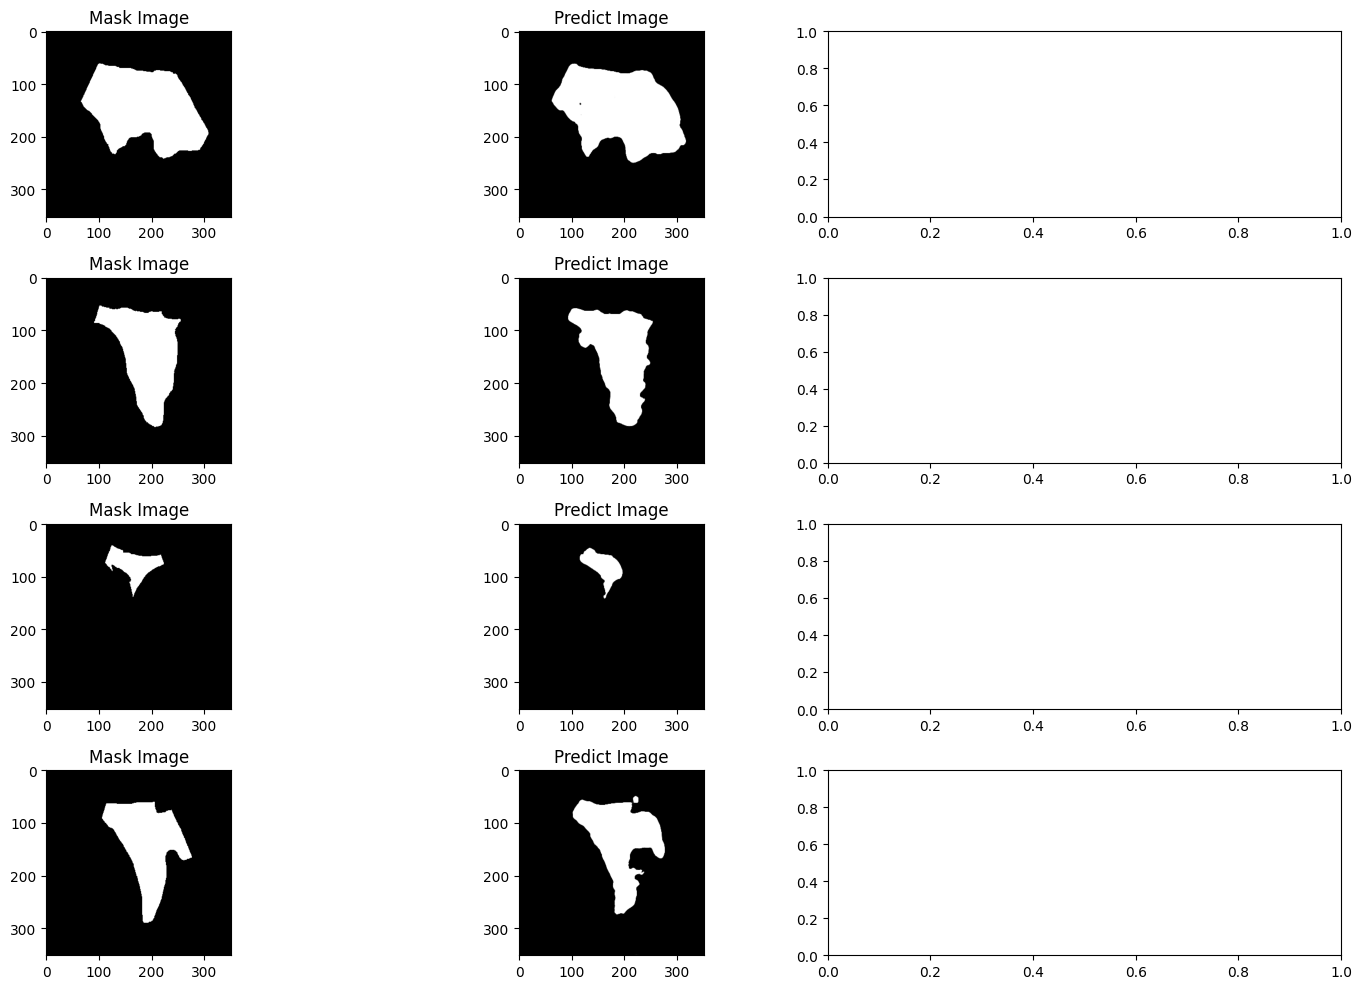

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_DuckNet_17_kvasir.txt
File done


In [77]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(4, 3, figsize=(15, 10))

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')